# get latents

In [ ]:
import torch
import pandas as pd
from pathlib import Path
from sae.inference import load_sae

# ------------------------------
# Inputs you already have
# ------------------------------
acts_path = "/maiziezhou_lab2/yunfei/Projects/interpTFM/activations_cosmx_lung_cancer/activations/layer_4/shard_0/activations.pt"
ckpt_path = "/maiziezhou_lab2/yunfei/Projects/FM_temp/interGFM/sae/sae_output_layer4/ae_normalized.pt"  # SAE trained on layer_4
# meta_df already loaded:
meta_df = pd.read_csv(
    "/maiziezhou_lab2/yunfei/Projects/interpTFM/activations_cosmx_lung_cancer/gene_ids/shard_0/cell_gene_pairs.txt",
    sep="\t", header=None, names=["cell_id", "gene_id"]
)

# ------------------------------
# Load activations + SAE
# ------------------------------
X = torch.load(acts_path)                  # shape: [N_tokens, H]
assert len(meta_df) == X.shape[0], "meta_df rows must match activation rows"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
sae = load_sae(ckpt_path).to(device).eval()

# ------------------------------
# Encode to SAE latents (batched)
# ------------------------------
def sae_encode_batched(X, model, batch_size=4096, device=device):
    latents = []
    with torch.no_grad():
        for i in range(0, X.shape[0], batch_size):
            xb = X[i:i+batch_size].to(device, non_blocking=True)
            if hasattr(model, "encode"):
                z = model.encode(xb)
            elif hasattr(model, "encoder"):
                z = model.encoder(xb)
            else:
                out = model(xb)
                # try (recon, z) or (z, recon)
                if isinstance(out, (tuple, list)) and len(out) >= 2:
                    # pick the latent by largest last-dim
                    z = out[0] if out[0].ndim == 2 and out[0].shape[1] != xb.shape[1] else out[1]
                else:
                    raise RuntimeError("SAE object lacks encode/encoder; adjust here.")
            latents.append(z.detach().cpu())
    return torch.cat(latents, dim=0)

Z = sae_encode_batched(X, sae, batch_size=4096)   # [N_tokens, K_latents]

# ------------------------------
# Build DataFrame with SAE features
# Columns are integer latent IDs to match f1_df['feature']
# ------------------------------
n_latents = Z.shape[1]
acts_df = pd.DataFrame(Z.numpy(), index=meta_df.index, columns=list(range(n_latents)))

print(f"SAE latents shape: {acts_df.shape}  (rows=tokens, cols=SAE features)")

# (optional) save for reuse
out_dir = Path("/maiziezhou_lab2/yunfei/Projects/interpTFM/activations_cosmx_lung_cancer/activations/layer_4/shard_0")
out_dir.mkdir(parents=True, exist_ok=True)
acts_df.to_parquet(out_dir / "sae_latents.parquet")

# prepare input

In [1]:
import scanpy as sc
import pandas as pd
import torch

# Metadata: cell-gene pairs
meta_df = pd.read_csv(
    "/maiziezhou_lab2/yunfei/Projects/interpTFM/activations_cosmx_lung_cancer/gene_ids/shard_0/cell_gene_pairs.txt",
    sep="\t", header=None, names=["cell_id", "gene_id"]
)

# Load your main dataframe
f1_df = pd.read_csv(
    "/maiziezhou_lab2/yunfei/Projects/FM_temp/interGFM/output/test/heldout_top_pairings.csv",
    index_col=0
)
f1_df["concept"] = f1_df["concept"].astype(str).str.strip().str.strip('"')
# Load the file with GO terms
go_df = pd.read_csv("/maiziezhou_lab2/yunfei/Projects/interpTFM/gprofiler_annotation/cosmx_lung_human_gp_go_kegg_reactome.csv", usecols=["term_name", "term_id"])

# Merge: match f1_df['concept'] with go_df['term_name']
f1_df = f1_df.merge(go_df, left_on="concept", right_on="term_name", how="left")

# Activations
###### this is wrong, let's try to use the SAE latents to replace thiss
acts_df = pd.read_parquet("/maiziezhou_lab2/yunfei/Projects/interpTFM/activations_cosmx_lung_cancer/activations/layer_4/shard_0/sae_latents.parquet")


# Load h5ad to get cell types
adata = sc.read_h5ad("/maiziezhou_lab2/yunfei/Projects/FM_temp/InterPLM/interplm/ge_shards/cosmx_human_lung_sec8.h5ad")
celltype_map = adata.obs["author_cell_type"].to_dict()  # dict: cell_id → cell_type

# Add cell_type to meta_df
meta_df["cell_type"] = meta_df["cell_id"].map(celltype_map)

In [52]:
acts_df

,0,1,2,3,4,5,6,7,8,9,...,4086,4087,4088,4089,4090,4091,4092,4093,4094,4095
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
516875,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
516876,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
516877,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
516878,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
f1_df

,concept,feature,threshold_pct,precision,recall,f1,tp,fp,tp_per_domain,term_name,term_id
0,positive regulation of vascular associated smo...,208,0.15,1.000000,1.000000,1.000000,542.0,0.0,0.0,positive regulation of vascular associated smo...,GO:1904707
1,negative regulation of endothelial cell migration,2430,0.15,1.000000,1.000000,1.000000,425.0,0.0,0.0,negative regulation of endothelial cell migration,GO:0010596
2,regulation of DNA biosynthetic process,71,0.15,0.993981,0.951049,0.972041,2312.0,14.0,0.0,regulation of DNA biosynthetic process,GO:2000278
3,"regulation of DNA damage response, signal tran...",71,0.15,0.993981,0.951049,0.972041,2312.0,14.0,0.0,"regulation of DNA damage response, signal tran...",GO:0043516
4,peptide secretion,1725,0.15,0.996429,0.933110,0.963731,558.0,2.0,0.0,peptide secretion,GO:0002790
...,...,...,...,...,...,...,...,...,...,...,...
1788,glomerular mesangium development,2296,0.50,0.017703,0.258278,0.033135,39.0,2164.0,0.0,glomerular mesangium development,GO:0072109
1789,morphogenesis of an epithelial sheet,3760,0.60,0.026374,0.029925,0.028037,12.0,443.0,0.0,morphogenesis of an epithelial sheet,GO:0002011
1790,extracellular matrix disassembly,1309,0.15,0.012403,0.548193,0.024257,91.0,7246.0,0.0,extracellular matrix disassembly,GO:0022617
1791,peptidyl-tyrosine autophosphorylation,238,0.60,0.007222,0.260116,0.014054,45.0,6186.0,0.0,peptidyl-tyrosine autophosphorylation,GO:0038083


In [2]:
meta_df

,cell_id,gene_id,cell_type
0,96_1-6,<cls>,tumor 13
1,96_1-6,ABL1,tumor 13
2,96_1-6,ADGRA3,tumor 13
3,96_1-6,ADGRE5,tumor 13
4,96_1-6,ADM2,tumor 13
...,...,...,...
516875,3880_20-3,<pad>,T CD4 memory
516876,3880_20-3,<pad>,T CD4 memory
516877,3880_20-3,<pad>,T CD4 memory
516878,3880_20-3,<pad>,T CD4 memory


/home/huy21/anaconda3/envs/scgpt_analysis/lib/python3.10/site-packages/goatools/__init__.py:2: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution, DistributionNotFound


go-basic.obo: fmt(1.2) rel(2025-07-22) 43,230 Terms
                                             concept     term_id  \
0  positive regulation of vascular associated smo...  GO:1904707   
1  negative regulation of endothelial cell migration  GO:0010596   
2             regulation of DNA biosynthetic process  GO:2000278   
3  regulation of DNA damage response, signal tran...  GO:0043516   
4                                  peptide secretion  GO:0002790   

                                        parent_terms  
0  [regulation of vascular associated smooth musc...  
1  [negative regulation of locomotion, negative r...  
2  [regulation of cellular process, regulation of...  
3  [regulation of intracellular signal transducti...  
4  [nitrogen compound transport, peptide transpor...  
[('biological_process', 1581), ('biological regulation', 928), ('regulation of biological process', 893), ('regulation of cellular process', 710), ('cellular process', 378), ('positive regulation of biological

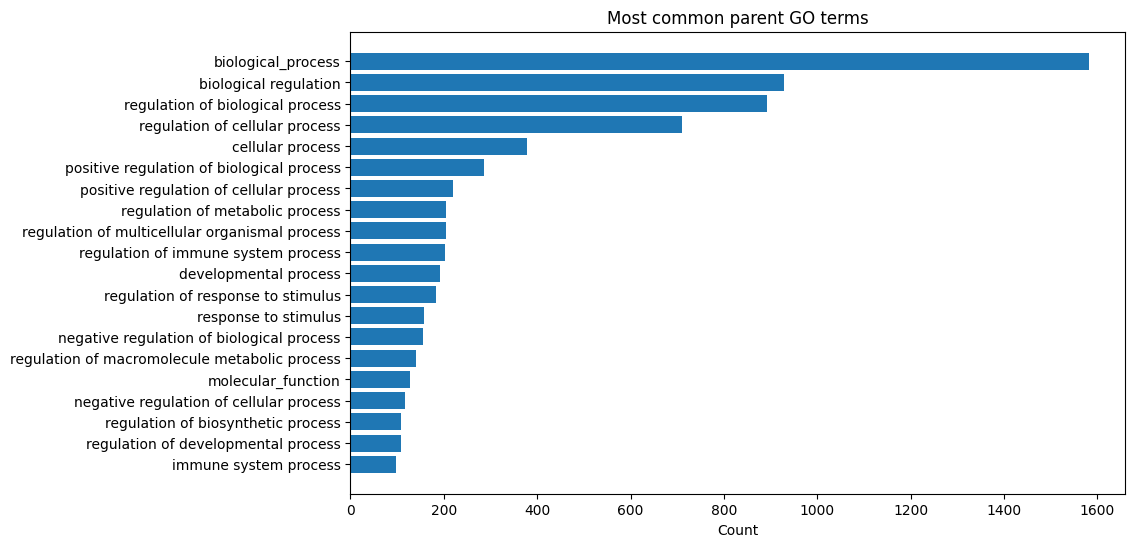

In [14]:
from goatools.obo_parser import GODag

# Load the ontology (download go-basic.obo once)
go_dag = GODag("go-basic.obo")

def get_parent_terms(go_id, dag):
    if go_id not in dag:
        return []
    term = dag[go_id]
    parents = []
    for parent in term.parents:
        parents.append(parent.name)  # collect parent name in plain English
        parents.extend(get_parent_terms(parent.id, dag))  # recurse
    return list(set(parents))  # unique

# Add parent terms
f1_df["parent_terms"] = f1_df["term_id"].dropna().apply(lambda go: get_parent_terms(go, go_dag))

# Peek
print(f1_df[["concept", "term_id", "parent_terms"]].head())

from collections import Counter
import itertools

# Flatten all parent terms
all_parents = list(itertools.chain.from_iterable(f1_df["parent_terms"].dropna()))
parent_counts = Counter(all_parents)

# Top 20 parent terms
print(parent_counts.most_common(20))

import matplotlib.pyplot as plt

top_n = 20
labels, values = zip(*parent_counts.most_common(top_n))

plt.figure(figsize=(10,6))
plt.barh(labels, values)
plt.gca().invert_yaxis()
plt.title("Most common parent GO terms")
plt.xlabel("Count")
plt.show()


Number of terms passing f1 > 0.75: 106
regulation of cytokine production	7
regulation of cell motility	5
regulation of cell migration	5
regulation of locomotion	5
regulation of cell population proliferation	4
cell activation	4
animal organ development	4
intracellular signal transduction	4
regulation of intracellular signal transduction	3
regulation of apoptotic process	3
positive regulation of programmed cell death	3
positive regulation of apoptotic process	3
regulation of programmed cell death	3
leukocyte activation	3
regulation of innate immune response	3
regulation of defense response	3
regulation of response to biotic stimulus	3
regulation of cell activation	3
macromolecule biosynthetic process	3
positive regulation of immune system process	3
regulation of endothelial cell migration	2
negative regulation of locomotion	2
negative regulation of cell migration	2
negative regulation of cell motility	2
lymphocyte activation	2


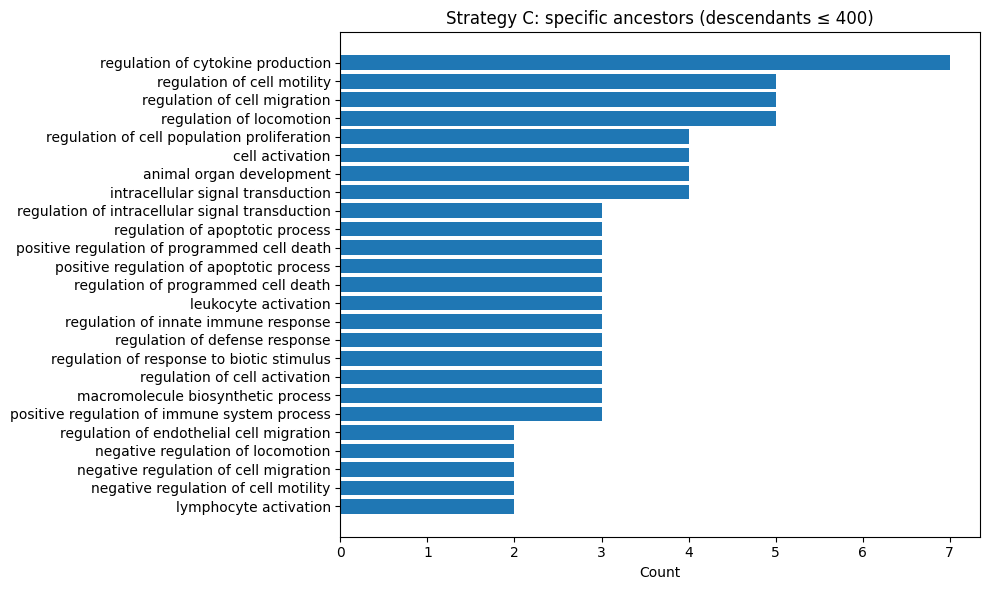

In [21]:
# ==== Strategy C: keep only "specific" ancestors (by descendant count) ====
# Prereqs: pip install goatools pandas matplotlib
# Also download go-basic.obo from GO (http://purl.obolibrary.org/obo/go/go-basic.obo)

import itertools
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
from goatools.obo_parser import GODag

# --- Config ---
GO_OBO_PATH = "go-basic.obo"     # set to your path
MAX_DESCENDANTS = 400            # ancestors with > this many descendants are considered too broad
TOP_N = 25                       # how many categories to plot
THRESHOLD = 0.75   # change to 0.75 to test stricter filtering

# --- Inputs ---
# Assumes you already have f1_df in memory with a 'term_id' column (GO:XXXXXX).
# If not, load it here:
# f1_df = pd.read_csv("your_file_with_termid.csv")

# Choose filter threshold

df = f1_df[(f1_df["f1"] > THRESHOLD) & f1_df["term_id"].notna()].copy()
df["term_id"] = df["term_id"].astype(str).str.strip()
print(f"Number of terms passing f1 > {THRESHOLD}: {len(df)}")

# --- Helpers ---
def _descendants_count(term):
    """Count descendants (children recursively) of a GO term."""
    seen = set()
    stack = list(term.children)
    while stack:
        t = stack.pop()
        if t.id not in seen:
            seen.add(t.id)
            stack.extend(t.children)
    return len(seen)

_desc_cache = {}
def descendants_count(go_id):
    if go_id not in go:
        return 0
    if go_id in _desc_cache:
        return _desc_cache[go_id]
    n = _descendants_count(go[go_id])
    _desc_cache[go_id] = n
    return n

def ancestors(go_id):
    """Return all ancestor GOTerms (parents recursively)."""
    if go_id not in go:
        return []
    out, stack = set(), list(go[go_id].parents)
    while stack:
        p = stack.pop()
        if p.id not in out:
            out.add(p.id)
            stack.extend(p.parents)
    return [go[pid] for pid in out if pid in go]

def specific_ancestors(go_id, max_desc=MAX_DESCENDANTS):
    """Ancestors with descendant count <= max_desc."""
    keep = []
    for a in ancestors(go_id):
        if descendants_count(a.id) <= max_desc:
            keep.append(a)
    return keep

# --- Compute per-row specific parents ---
df["specific_parents"] = df["term_id"].apply(specific_ancestors)

# --- Aggregate counts across all rows ---
names = list(itertools.chain.from_iterable([[t.name for t in xs] for xs in df["specific_parents"]]))
parent_counts = Counter(names)

# --- Show / save top categories ---
top = parent_counts.most_common(TOP_N)
for name, cnt in top:
    print(f"{name}\t{cnt}")

# Optional: save CSVs
pd.DataFrame(parent_counts.most_common(), columns=["term_name", "count"]).to_csv(
    "strategyC_counts.csv", index=False
)
df_out = df[["concept", "term_id", "specific_parents"]].copy()
df_out["specific_parents"] = df_out["specific_parents"].apply(lambda xs: "; ".join(sorted(set(t.name for t in xs))))
df_out.to_csv("strategyC_parents_by_row.csv", index=False)

# --- Barplot ---
if top:
    labels, values = zip(*top)
    plt.figure(figsize=(10, 6))
    plt.barh(labels, values)               # (no custom colors/styles per your plotting rules)
    plt.gca().invert_yaxis()
    plt.title(f"Strategy C: specific ancestors (descendants ≤ {MAX_DESCENDANTS})")
    plt.xlabel("Count")
    plt.tight_layout()
    plt.show()
else:
    print("No specific ancestors found with current threshold.")


# clustering-based match

In [17]:
# ============================
# Match best-F1 feature vs GO single-parent label per concept
# Grid-search MAX_DESCENDANTS (+ optional F1_MIN)
# Metrics: ARI & NMI
# ============================

import numpy as np
import pandas as pd
from collections import Counter
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, adjusted_mutual_info_score
from goatools.obo_parser import GODag

# --------------------------------
# Inputs & assumptions
# --------------------------------
# f1_df must have: ['concept','feature','f1','term_id'] (term_id is GO:XXXXXX)
# If not in memory, load it:
# f1_df = pd.read_csv("/path/to/heldout_top_pairings.csv", index_col=0)

GO_OBO_PATH = "go-basic.obo"   # path to your ontology

# --------------------------------
# Strategy C helpers (same as before)
# --------------------------------
go = GODag(GO_OBO_PATH, load_obsolete=False)

def _descendants_count(term):
    seen = set()
    stack = list(term.children)
    while stack:
        t = stack.pop()
        if t.id not in seen:
            seen.add(t.id)
            stack.extend(t.children)
    return len(seen)

_desc_cache = {}
def descendants_count(go_id):
    if go_id not in go:
        return 0
    if go_id in _desc_cache:
        return _desc_cache[go_id]
    n = _descendants_count(go[go_id])
    _desc_cache[go_id] = n
    return n

def ancestors(go_id):
    if go_id not in go:
        return []
    out, stack = set(), list(go[go_id].parents)
    while stack:
        p = stack.pop()
        if p.id not in out:
            out.add(p.id)
            stack.extend(p.parents)
    return [go[pid] for pid in out if pid in go]

def specific_ancestors(go_id, max_desc):
    keep = []
    for a in ancestors(go_id):
        if descendants_count(a.id) <= max_desc:
            keep.append(a)
    return keep

def term_depth(term):
    return getattr(term, "depth", getattr(term, "level", 0))

# --------------------------------
# One-parent chooser (fewest descendants → deepest → most frequent → ID)
# --------------------------------
def choose_one_parent(parent_terms, freq_by_id):
    if not parent_terms:
        return None
    uniq = {t.id: t for t in parent_terms}.values()
    def score_parent(term):
        return (descendants_count(term.id), -term_depth(term), -freq_by_id[term.id], term.id)
    return min(uniq, key=score_parent)

# --------------------------------
# Build labels
# --------------------------------
def best_f1_feature_per_concept(f1_df, f1_min=None):
    """Return Series: concept -> best feature (argmax f1). Optionally drop concepts with best f1 < f1_min."""
    # pick row with max f1 per concept; break ties by highest f1 then lexical feature
    g = (f1_df.assign(feature=f1_df["feature"].astype(str))
               .sort_values(["concept","f1","feature"], ascending=[True, False, True])
               .groupby("concept", sort=False)
               .head(1))
    if f1_min is not None:
        g = g[g["f1"] >= f1_min]
    return g.set_index("concept")["feature"]

def go_parent_per_concept(f1_df, concepts, max_desc):
    """Return Series: concept -> chosen GO parent name (Strategy C single parent)."""
    term_map = (f1_df.dropna(subset=["term_id"])
                     .groupby("concept")["term_id"]
                     .first()
                     .reindex(concepts))
    parent_sets = []
    all_terms = []
    for go_id in term_map.values:
        if pd.isna(go_id):
            parent_sets.append([])
            continue
        parents = specific_ancestors(str(go_id), max_desc)
        parent_sets.append(parents)
        all_terms.extend(parents)
    if not all_terms:
        return pd.Series(index=concepts, dtype=object)
    freq_by_id = Counter(t.id for t in all_terms)
    chosen = [choose_one_parent(ps, freq_by_id) for ps in parent_sets]
    names = [t.name if t else None for t in chosen]
    return pd.Series(names, index=concepts, dtype=object)

# --------------------------------
# Encode string labels to integers for ARI/NMI
# --------------------------------
def encode_labels(series):
    """Map unique non-null labels to 0..C-1; null stays as NaN to allow intersection filtering."""
    vals = series.dropna().unique().tolist()
    lut = {v:i for i,v in enumerate(sorted(vals))}
    return series.map(lut)

# --------------------------------
# Grid search
# --------------------------------
MAX_DESC_LIST = [50, 150, 300, 400, 500, 750, 1000]
F1_MIN_LIST   = [0.5, 0.75, 0.9]

rows = []
for f1_min in F1_MIN_LIST:
    # F1 labels (no clustering): concept -> best feature
    f1_lab = best_f1_feature_per_concept(f1_df, f1_min=f1_min)
    if f1_lab.empty:
        continue

    # NEW: left-side counts after F1 filtering (before intersecting with GO)
    n_concepts_f1 = int(len(f1_lab))
    n_features_f1 = int(f1_lab.nunique())

    # concept set we’ll evaluate on = those that also have a term_id available (GO side will drop empties anyway)
    eval_concepts = f1_lab.index.tolist()

    for md in MAX_DESC_LIST:
        go_lab = go_parent_per_concept(f1_df, eval_concepts, max_desc=md)

        # Align to concepts having both labels
        mask = (~f1_lab.reindex(eval_concepts).isna()) & (~go_lab.isna())
        if mask.sum() < 2:
            continue

        f1_enc = encode_labels(f1_lab[mask])
        go_enc = encode_labels(go_lab[mask])

        # Right-side/eval counts (after intersecting)
        n_eval_concepts = int(mask.sum())
        n_f1_labels = int(f1_enc.nunique())
        n_go_labels = int(go_enc.nunique())

        # Metrics
        nmi = normalized_mutual_info_score(f1_enc.values, go_enc.values)
        ami = adjusted_mutual_info_score(f1_enc.values, go_enc.values)

        rows.append({
            "f1_min": f1_min if f1_min is not None else -1,
            "max_descendants": md,
            # NEW: left-side (F1) counts after filtering, before intersection with GO
            "n_concepts_f1": n_concepts_f1,
            "n_features_f1": n_features_f1,
            # Existing/eval counts (after intersection)
            "n_eval_concepts": n_eval_concepts,
            "n_f1_labels": n_f1_labels,
            "n_go_labels": n_go_labels,
            # Metrics
            "NMI": float(nmi),
            # "AMI": float(ami),
        })

results = (pd.DataFrame(rows)
           .sort_values(["NMI","n_go_labels"], ascending=[False, False]))
print("Top 12 settings (best match between best-F1 feature vs GO parent):")
print(results.head(12).to_string(index=False))


# --------------------------------
# Inspect the best setting with a confusion table
# --------------------------------
if not results.empty:
    best = results.iloc[0]
    f1_min = None if best["f1_min"] == -1 else float(best["f1_min"])
    md     = int(best["max_descendants"])

    f1_lab = best_f1_feature_per_concept(f1_df, f1_min=f1_min)
    go_lab = go_parent_per_concept(f1_df, f1_lab.index.tolist(), max_desc=md)

    mask = (~f1_lab.isna()) & (~go_lab.isna())
    f1_use = f1_lab[mask]
    go_use = go_lab[mask]

    print(f"\nBest setting details: f1_min={f1_min}, max_descendants={md}, n={mask.sum()}")
    print(f"Unique F1 labels: {f1_use.nunique()}, Unique GO parent labels: {go_use.nunique()}")

    # Confusion (top rows/cols)
    cm = pd.crosstab(go_use, f1_use)  # rows=GO parent, cols=best F1 feature
    # Show the heaviest GO parents
    heavy = cm.sum(axis=1).sort_values(ascending=False).head(20).index
    cm_view = cm.loc[heavy, cm.sum(axis=0).sort_values(ascending=False).head(20).index]
    print("\nConfusion table (top 20x20):")
    print(cm_view)

    # Optional: save full confusion table
    # cm.to_csv(f"confusion_goParent_vs_bestF1_f1min_{f1_min}_maxdesc_{md}.csv")


go-basic.obo: fmt(1.2) rel(2025-07-22) 43,230 Terms
Top 12 settings (best match between best-F1 feature vs GO parent):
 f1_min  max_descendants  n_concepts_f1  n_features_f1  n_eval_concepts  n_f1_labels  n_go_labels      NMI
   0.90              150             19             15               12           10           12 0.941503
   0.90              300             19             15               14           11           14 0.932350
   0.90              400             19             15               16           12           16 0.926581
   0.90              500             19             15               16           12           16 0.926581
   0.90              750             19             15               16           12           16 0.926581
   0.90             1000             19             15               16           12           16 0.926581
   0.90               50             19             15                9            7            9 0.909091
   0.75               50 

/home/huy21/anaconda3/envs/scgpt_analysis/lib/python3.10/site-packages/sklearn/metrics/cluster/_supervised.py:50: UserWarning: The number of unique classes is greater than 50% of the number of samples. `y` could represent a regression problem, not a classification problem.
  type_pred = type_of_target(labels_pred)
/home/huy21/anaconda3/envs/scgpt_analysis/lib/python3.10/site-packages/sklearn/metrics/cluster/_supervised.py:50: UserWarning: The number of unique classes is greater than 50% of the number of samples. `y` could represent a regression problem, not a classification problem.
  type_pred = type_of_target(labels_pred)
/home/huy21/anaconda3/envs/scgpt_analysis/lib/python3.10/site-packages/sklearn/metrics/cluster/_supervised.py:50: UserWarning: The number of unique classes is greater than 50% of the number of samples. `y` could represent a regression problem, not a classification problem.
  type_pred = type_of_target(labels_pred)
/home/huy21/anaconda3/envs/scgpt_analysis/lib/python

In [18]:
results

,f1_min,max_descendants,n_concepts_f1,n_features_f1,n_eval_concepts,n_f1_labels,n_go_labels,NMI
15,0.90,150,19,15,12,10,12,0.941503
16,0.90,300,19,15,14,11,14,0.932350
17,0.90,400,19,15,16,12,16,0.926581
18,0.90,500,19,15,16,12,16,0.926581
19,0.90,750,19,15,16,12,16,0.926581
20,0.90,1000,19,15,16,12,16,0.926581
14,0.90,50,19,15,9,7,9,0.909091
7,0.75,50,106,43,41,24,40,0.887953
8,0.75,150,106,43,57,31,54,0.877804
10,0.75,400,106,43,86,39,79,0.848997


Top by NMI:
 top_k  min_count  n_eval_concepts  n_f1_labels  n_go_labels      NMI       AMI
    25         10              339           82          280 0.764804  0.007436
    50         10              339           82          280 0.764804  0.007436
    75         10              339           82          280 0.764804  0.007436
   100         10              339           82          280 0.764804  0.007436
   150         10              339           82          280 0.764804  0.007436
   150         -1              339           82          151 0.575041 -0.017810
   100         -1              339           82          101 0.491410  0.014226
    75         -1              339           82           76 0.432319  0.012979
    50         -1              339           82           51 0.360059  0.005728
    50          2              339           82           40 0.319205 -0.005021

Top by AMI:
 top_k  min_count  n_eval_concepts  n_f1_labels  n_go_labels      NMI      AMI
   100         -

/home/huy21/anaconda3/envs/scgpt_analysis/lib/python3.10/site-packages/sklearn/metrics/cluster/_supervised.py:50: UserWarning: The number of unique classes is greater than 50% of the number of samples. `y` could represent a regression problem, not a classification problem.
  type_pred = type_of_target(labels_pred)
/home/huy21/anaconda3/envs/scgpt_analysis/lib/python3.10/site-packages/sklearn/metrics/cluster/_supervised.py:50: UserWarning: The number of unique classes is greater than 50% of the number of samples. `y` could represent a regression problem, not a classification problem.
  type_pred = type_of_target(labels_pred)
/home/huy21/anaconda3/envs/scgpt_analysis/lib/python3.10/site-packages/sklearn/metrics/cluster/_supervised.py:50: UserWarning: The number of unique classes is greater than 50% of the number of samples. `y` could represent a regression problem, not a classification problem.
  type_pred = type_of_target(labels_pred)
/home/huy21/anaconda3/envs/scgpt_analysis/lib/python

# reducing GO terms

In [ ]:
# from sentence_transformers import SentenceTransformer
# from sklearn.metrics.pairwise import cosine_similarity
# from scipy.cluster.hierarchy import linkage, fcluster
# import pandas as pd
# import numpy as np

# # Load your table
# df = f1_df[f1_df['f1']>0.5]

# concepts = df['concept'].tolist()

# # Compute embeddings
# model = SentenceTransformer('all-MiniLM-L6-v2')
# embeddings = model.encode(concepts, convert_to_numpy=True)

# # Compute cosine similarity
# sim_matrix = cosine_similarity(embeddings)

# # Convert to distance
# dist_matrix = 1 - sim_matrix

# # Hierarchical clustering
# Z = linkage(dist_matrix, method='complete')

# # Choose a threshold (0.2~0.3 usually works for text)
# threshold = 0.99
# clusters = fcluster(Z, t=threshold, criterion='distance')

# # Map concept -> cluster
# df['cluster'] = clusters

# # Select top F1 per cluster
# reduced_features = df.loc[df.groupby('cluster')['f1'].idxmax()]

# print("Original features:", len(df))
# print("Reduced features:", len(reduced_features))
# print(reduced_features[['concept','feature','f1']])


Original features: 392
Reduced features: 343
                                                concept  feature        f1
3184  negative regulation of small molecule metaboli...     2922  0.724670
6888     regulation of small molecule metabolic process      208  0.777061
6670            regulation of primary metabolic process      108  0.922088
6722            regulation of protein metabolic process      108  0.563048
6217              regulation of lipid metabolic process      462  0.823173
...                                                 ...      ...       ...
6352           regulation of mitochondrion organization     1819  0.689966
6799  regulation of release of cytochrome c from mit...      895  0.540850
5225             regulation of DNA biosynthetic process       71  0.972041
6909         regulation of steroid biosynthetic process     1658  0.607279
6765  regulation of purine nucleotide catabolic process     1617  0.587803

[343 rows x 3 columns]


/tmp/ipykernel_4038468/2260717280.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cluster'] = clusters


In [ ]:
from goatools.obo_parser import GODag
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

df = f1_df[f1_df['f1']>0.5]
# Load GO DAG
go_dag = GODag("go-basic.obo")

# Prepare GO term text (name + definition)
go_terms = list(go_dag.values())
go_texts = []
for term in go_terms:
    definition = getattr(term, 'defn', "")  # fallback to empty string if not present
    go_texts.append(term.name + " " + definition)

# Your annotations
concepts = df['concept'].tolist()

# Compute embeddings
model = SentenceTransformer('all-MiniLM-L6-v2')
concept_emb = model.encode(concepts, convert_to_numpy=True)
go_emb = model.encode(go_texts, convert_to_numpy=True)

# Cosine similarity
sim_matrix = cosine_similarity(concept_emb, go_emb)

# Pick best matching GO term for each concept
best_indices = np.argmax(sim_matrix, axis=1)
df['matched_go_id'] = [go_terms[idx].id for idx in best_indices]
df['matched_go_name'] = [go_terms[idx].name for idx in best_indices]
df['match_similarity'] = [sim_matrix[i, idx] for i, idx in enumerate(best_indices)]
df['match_similarity'] = df['match_similarity'].round(3)
# print(df[['concept','matched_go_id','matched_go_name','match_similarity']].head())


In [42]:
df

,concept,feature,threshold_pct,precision,recall,f1,tp,fp,tp_per_domain,cluster,matched_go_id,matched_go_name,match_similarity
4928,positive regulation of vascular associated smo...,208,0.15,1.000000,1.000000,1.000000,542.0,0.0,0.0,1053,GO:1904707,positive regulation of vascular associated smo...,1.000000
2782,negative regulation of endothelial cell migration,2430,0.15,1.000000,1.000000,1.000000,425.0,0.0,0.0,1018,GO:0010596,negative regulation of endothelial cell migration,1.000000
5225,regulation of DNA biosynthetic process,71,0.15,0.993981,0.951049,0.972041,2312.0,14.0,0.0,556,GO:2000278,regulation of DNA biosynthetic process,1.000000
5230,"""regulation of DNA damage response, signal tra...",71,0.15,0.993981,0.951049,0.972041,2312.0,14.0,0.0,1735,GO:0043516,"regulation of DNA damage response, signal tran...",0.966801
3501,peptide secretion,1725,0.15,0.996429,0.933110,0.963731,558.0,2.0,0.0,1681,GO:0002790,peptide secretion,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7874,supramolecular fiber organization,895,0.15,0.462965,0.545388,0.500808,4494.0,5213.0,0.0,1149,GO:0097435,supramolecular fiber organization,1.000000
1975,lipid binding,3210,0.60,0.523828,0.479592,0.500735,1363.0,1239.0,0.0,1740,GO:0008289,lipid binding,1.000000
2401,multicellular organism development,3210,0.60,0.523828,0.479592,0.500735,1363.0,1239.0,0.0,1463,GO:0007275,multicellular organism development,1.000000
1472,immune system process,2316,0.15,0.929809,0.342282,0.500368,1020.0,77.0,0.0,423,GO:0002376,immune system process,1.000000


In [51]:
df['concept'].to_list()

['positive regulation of vascular associated smooth muscle cell proliferation',
 'negative regulation of endothelial cell migration',
 'regulation of DNA biosynthetic process',
 '"regulation of DNA damage response, signal transduction by p53 class mediator"',
 'peptide secretion',
 'positive regulation of endothelial cell apoptotic process',
 'alpha-beta T cell activation involved in immune response',
 'regulation of primary metabolic process',
 'response to temperature stimulus',
 'regulation of natural killer cell mediated immunity',
 'lytic vacuole',
 'lipid localization',
 'regulation of adaptive immune response based on somatic recombination of immune receptors built from immunoglobulin superfamily domains',
 'syncytium formation by plasma membrane fusion',
 'cellular response to oxidative stress',
 'regulation of catalytic activity',
 'embryonic digestive tract development',
 'regulation of immune effector process',
 'carbohydrate derivative binding',
 'negative regulation of B c

In [46]:
all_annotated_go = set(g for genes in gene2go.values() for g in genes)
missing_go = [go for go in matched_go_ids if go not in all_annotated_go]
print("GO IDs with no annotations:", missing_go)

GO IDs with no annotations: []


In [47]:
invalid_go = [go for go in matched_go_ids if go not in go_dag]
print("Invalid GO IDs:", invalid_go)

Invalid GO IDs: []


In [49]:
termcounts = TermCounts(go_dag, gene2go)
for go_id in matched_go_ids[:10]:
    print(go_id, termcounts.get_info_content(go_id))

AttributeError: 'TermCounts' object has no attribute 'get_info_content'

In [43]:
import pandas as pd
import numpy as np
from goatools.obo_parser import GODag
from goatools.semantic import TermCounts, semantic_similarity
from scipy.cluster.hierarchy import linkage, fcluster

# ============================
# Step 0: Load your concept-F1 table
# ============================
matched_go_ids = df['matched_go_id'].unique().tolist()

# ============================
# Step 1: Load GO DAG
# ============================
obo_file = "go-basic.obo"
go_dag = GODag(obo_file)

# ============================
# Step 2: Ensure gene2go mapping contains all GO IDs
# ============================
# gene2go should be your real gene → GO mapping dictionary
# Example: gene2go = {'gene1': ['GO:00001', 'GO:00002'], ...}
# Example: each concept is assigned a “dummy gene” for its matched GO ID
# Only use this if you do not have real gene annotations
gene2go = {f"gene_{i}": [go_id] for i, go_id in enumerate(df['matched_go_id'].unique())}


# Check which GO IDs are actually in gene2go
all_annotated_go = set(g for genes in gene2go.values() for g in genes)
missing_go = [go for go in matched_go_ids if go not in all_annotated_go]

if missing_go:
    print(f"Warning: {len(missing_go)} GO IDs not annotated to any gene. They will get IC=0.")

# ============================
# Step 3: Compute TermCounts
# ============================
termcounts = TermCounts(go_dag, gene2go)

# ============================
# Step 4: Compute semantic similarity matrix (Resnik)
# ============================
n_terms = len(matched_go_ids)
sim_matrix_go = np.zeros((n_terms, n_terms))

for i, t1 in enumerate(matched_go_ids):
    for j, t2 in enumerate(matched_go_ids):
        if i <= j:
            try:
                # Resnik similarity (handles missing IC internally)
                sim = semantic_similarity(t1, t2, go_dag, termcounts, method='resnik')
            except:
                sim = 0
            sim_matrix_go[i, j] = sim
            sim_matrix_go[j, i] = sim  # symmetric

# ============================
# Step 5: Convert similarity → distance
# ============================
# Normalize by max similarity to get [0,1]
max_sim = np.max(sim_matrix_go)
if max_sim == 0:
    print("Warning: all similarities are zero. Check gene2go mapping.")
    dist_matrix = np.ones_like(sim_matrix_go)
else:
    dist_matrix = 1 - sim_matrix_go / max_sim

# ============================
# Step 6: Hierarchical clustering
# ============================
from scipy.spatial.distance import squareform
condensed_dist = squareform(dist_matrix)
Z = linkage(condensed_dist, method='average')

# Automatically choose threshold (e.g., 10th percentile of distances)
threshold = np.percentile(dist_matrix.flatten(), 10)
clusters = fcluster(Z, t=threshold, criterion='distance')

# Map GO ID → cluster
go_to_cluster = {go_id: cluster for go_id, cluster in zip(matched_go_ids, clusters)}
df['cluster'] = df['matched_go_id'].map(go_to_cluster)

# ============================
# Step 7: Select top F1 per cluster
# ============================
reduced_features = df.loc[df.groupby('cluster')['f1'].idxmax()].reset_index(drop=True)

# ============================
# Step 8: Inspect results
# ============================
print("Original features:", len(df))
print("Reduced features:", len(reduced_features))
print(reduced_features[['concept','matched_go_id','matched_go_name','f1']].head(20))

# Optionally save
# reduced_features.to_csv("concepts_reduced_go.csv", index=False)


go-basic.obo: fmt(1.2) rel(2025-07-22) 43,230 Terms


ValueError: Distance matrix 'X' diagonal must be zero.

In [45]:
gene2go

{'gene_0': ['GO:1904707'],
 'gene_1': ['GO:0010596'],
 'gene_2': ['GO:2000278'],
 'gene_3': ['GO:0043516'],
 'gene_4': ['GO:0002790'],
 'gene_5': ['GO:2000353'],
 'gene_6': ['GO:0002287'],
 'gene_7': ['GO:0080090'],
 'gene_8': ['GO:0009266'],
 'gene_9': ['GO:0002715'],
 'gene_10': ['GO:0000323'],
 'gene_11': ['GO:0010876'],
 'gene_12': ['GO:0002822'],
 'gene_13': ['GO:0000768'],
 'gene_14': ['GO:0034599'],
 'gene_15': ['GO:0050790'],
 'gene_16': ['GO:0048566'],
 'gene_17': ['GO:0002697'],
 'gene_18': ['GO:0097367'],
 'gene_19': ['GO:0030889'],
 'gene_20': ['GO:0032615'],
 'gene_21': ['GO:1903522'],
 'gene_22': ['GO:0043903'],
 'gene_23': ['GO:0050789'],
 'gene_24': ['GO:0034764'],
 'gene_25': ['GO:0032700'],
 'gene_26': ['GO:0090504'],
 'gene_27': ['GO:0001516'],
 'gene_28': ['GO:0050886'],
 'gene_29': ['GO:0031018'],
 'gene_30': ['GO:0098727'],
 'gene_31': ['GO:0032386'],
 'gene_32': ['GO:0003206'],
 'gene_33': ['GO:1901701'],
 'gene_34': ['GO:2001238'],
 'gene_35': ['GO:0050678'],
 '

In [ ]:
import requests

# ============================
# Step 0: Download GO OBO if needed
# ============================
url = "http://purl.obolibrary.org/obo/go/go-basic.obo"
response = requests.get(url)
with open("go-basic.obo", "wb") as f:
    f.write(response.content)

go-basic.obo downloaded successfully!


In [19]:
import pandas as pd
import numpy as np
from goatools.obo_parser import GODag
from goatools.semantic import semantic_similarity, TermCounts
from scipy.cluster.hierarchy import linkage, fcluster


# ============================
# Step 1: Load GO DAG
# ============================
obo_file = "go-basic.obo"
go_dag = GODag(obo_file)

# ============================
# Step 2: Load your GO concept-F1 table
# ============================
df = f1_df
# Columns: concept, feature (GO ID), f1, etc.

# Make sure feature column is string
df['concept'] = df['concept'].astype(str)
go_terms = df['concept'].unique().tolist()

# ============================
# Step 3: Build gene -> GO mapping
# ============================
# Here we create a dummy gene2go mapping just to compute TermCounts
# Replace with your real gene -> GO dictionary if you have it
# For each GO feature, assign one “dummy gene” to allow IC calculation
gene2go = {f"gene_{i}": [go_id] for i, go_id in enumerate(go_terms)}

# Compute TermCounts for semantic similarity
termcounts = TermCounts(go_dag, gene2go)

# ============================
# Step 4: Compute semantic similarity matrix
# ============================
sim_matrix = np.zeros((len(go_terms), len(go_terms)))

for i, t1 in enumerate(go_terms):
    for j, t2 in enumerate(go_terms):
        if i <= j:
            try:
                sim = semantic_similarity(t1, t2, go_dag, termcounts, method='resnik')
            except:
                sim = 0
            sim_matrix[i,j] = sim
            sim_matrix[j,i] = sim  # symmetric

# ============================
# Step 5: Hierarchical clustering
# ============================
dist_matrix = 1 - sim_matrix  # similarity → distance
Z = linkage(dist_matrix, method='average')

# Tune this threshold: smaller = more clusters
threshold = 0.9
clusters = fcluster(Z, t=threshold, criterion='distance')

# Map GO term → cluster
go_to_cluster = {term: cluster for term, cluster in zip(go_terms, clusters)}

# ============================
# Step 6: Select top F1 per cluster
# ============================
reduced_features = []

for cluster_id in np.unique(clusters):
    cluster_terms = [term for term, cid in go_to_cluster.items() if cid == cluster_id]
    # Select the term with highest F1 in this cluster
    best_term = df[df['feature'].isin(cluster_terms)].sort_values('f1', ascending=False).iloc[0]
    reduced_features.append(best_term)

reduced_df = pd.DataFrame(reduced_features)

# ============================
# Step 7: Save or inspect
# ============================
print("Original features:", len(df))
print("Reduced features:", len(reduced_df))
print(reduced_df[['concept','feature','f1']].head(20))

# reduced_df.to_csv("concepts_reduced.csv", index=False)


go-basic.obo: fmt(1.2) rel(2025-07-22) 43,230 Terms
**NOTE: 43,230 SOURCE GO IDS


IndexError: single positional indexer is out-of-bounds

In [21]:
from sentence_transformers import SentenceTransformer
import numpy as np

concepts = ["positive regulation of vascular associated smooth muscle cell proliferation",
            "negative regulation of endothelial cell migration"]

go_terms = list(go_dag.values())
go_texts = [term.name + " " + (term.definition or "") for term in go_terms]

model = SentenceTransformer('all-MiniLM-L6-v2')
concept_emb = model.encode(concepts, convert_to_numpy=True)
go_emb = model.encode(go_texts, convert_to_numpy=True)

# Cosine similarity
from sklearn.metrics.pairwise import cosine_similarity
sim_matrix = cosine_similarity(concept_emb, go_emb)

# For each concept, pick best GO term
best_indices = np.argmax(sim_matrix, axis=1)
for i, idx in enumerate(best_indices):
    print("Concept:", concepts[i])
    print("Matched GO ID:", go_terms[idx].id)
    print("Matched GO name:", go_terms[idx].name)
    print("Similarity:", sim_matrix[i, idx])


ModuleNotFoundError: No module named 'sentence_transformers'